# Basin gcm processing

What we want to do here:
- Download gcm data.
- Fetch shapefile for a basin.
- Select gridpoints from gcm data that are within this shapefile.
- Bias correct them. Inspiration from the OGGM.
- Take a mean of temperature of these gridpoints. 
- Total of precipitation?

In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import shapely.geometry as shpg
from matplotlib import pyplot as plt
import pandas as pd
from oggm import utils
import zipfile

## Downloading the data

We need the cmip5 data, and the reference data (CRU).

In [2]:
def download_proj_data(rcp):
    '''
    Small helper function to download data.
    
    Args
    rcp: List of rcp scenarios.
    
    Returns
    ft: Path to temperature file
    fp: Path to precipitation files
    '''
    # Base file paths
    # Note that these dont contain any scenario data.
    bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-'+\
         'ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
    bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-'+\
          'ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
    # Download the data
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
        
    return ft, fp

In [3]:
def download_clim_data():
    
    f = 'https://cluster.klima.uni-bremen.de/~oggm/climate/cru/cru_cl2.nc.zip'
    fp = utils.file_downloader(f)
    with zipfile.ZipFile(fp, 'r') as zip_ref:
        zip_ref.extractall(fp[:-7])
    return fp[:-7] + '/cru_cl2.nc'

In [4]:
# Projection data
ft, fp = download_proj_data('rcp26')

In [5]:
# Reference climate data
f_cru = download_clim_data()

In [6]:
f_cru

'/home/erik/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/cru/cru_cl2/cru_cl2.nc'

Take a look at the data

In [7]:
with xr.open_dataset(ft) as ds:
    ds_t = ds.isel(time=slice(0, -1)).load()
    
ds_t

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 2771)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-15T12:00:00 1870-02-15 ... NaT NaT
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    tas      (time, lat, lon) float32 245.1 245.3 245.2 ... 248.1 248.2 248.2
Attributes:
    source_model:        CCSM4
    source_ensemble:     r1i1p1
    source_experiment:   historical,rcp26
    source_institution:  NCAR (National Center for Atmospheric Research) Boul...
    source_contact:      cesm_data@ucar.edu
    source_files:        tas_Amon_CCSM4_historical_r1i1p1_185001-200512.nc,ta...
    source_md5:          c8af45130a67bedc14271fa5613d27b2,56edb5417f4c8d1a8b2...
    freq:                monthly
    interpolation_grid:  2.5 x 2.5 degrees bilinear interpolation
    contact:             cmip5-archive@env.ethz.ch
    modifications:       nothing

In [97]:
with xr.open_dataset(fp) as ds:
    ds_p = ds.isel(time=slice(0, -1)).load()
    
ds_p.pr

<xarray.DataArray 'pr' (time: 2771, lat: 72, lon: 144)>
array([[[1.51401127e-06, 1.57900308e-06, 1.44869557e-06, ...,
         1.54116231e-06, 1.54052964e-06, 1.56760154e-06],
        [1.53287874e-06, 1.57560123e-06, 1.52381472e-06, ...,
         1.82778160e-06, 1.67836140e-06, 1.58898297e-06],
        [2.35272091e-06, 2.26012480e-06, 2.18420223e-06, ...,
         2.73454680e-06, 2.68914505e-06, 2.56139992e-06],
        ...,
        [9.99625172e-06, 1.01556143e-05, 9.92182686e-06, ...,
         1.09385828e-05, 1.06052157e-05, 1.02764425e-05],
        [9.91653906e-06, 9.66841071e-06, 9.65512481e-06, ...,
         9.32239800e-06, 9.89441833e-06, 9.25819586e-06],
        [8.15746807e-06, 8.15279509e-06, 8.18803164e-06, ...,
         7.97430766e-06, 8.09265930e-06, 8.27422718e-06]],

       [[1.30616581e-06, 1.32299181e-06, 1.30997523e-06, ...,
         1.32111961e-06, 1.30521153e-06, 1.28841077e-06],
        [4.09444425e-07, 3.96205735e-07, 4.44692859e-07, ...,
         4.13636911e-07, 3.64661844e-07, 4.09662988e-07],
        [4.21425142e-07, 4.37344312e-07, 4.36588778e-07, ...,
         4.81456937e-07, 4.42509673e-07, 4.25604668e-07],
...
        [8.50578090e-06, 9.30293118e-06, 9.72128146e-06, ...,
         5.99215491e-06, 6.45050113e-06, 7.41181839e-06],
        [8.47197771e-06, 9.05965317e-06, 1.02335316e-05, ...,
         6.37370749e-06, 7.43380906e-06, 7.99309510e-06],
        [1.28734173e-05, 1.33617768e-05, 1.29296877e-05, ...,
         1.19252554e-05, 1.24943545e-05, 1.25516608e-05]],

       [[6.65616790e-06, 6.73428303e-06, 6.80922949e-06, ...,
         6.63179617e-06, 6.70598638e-06, 6.65952530e-06],
        [2.30567707e-06, 2.28627050e-06, 2.37180757e-06, ...,
         2.38355005e-06, 2.38534653e-06, 2.26177804e-06],
        [2.49920390e-06, 2.36572578e-06, 2.29710849e-06, ...,
         2.61827608e-06, 2.58356818e-06, 2.61727541e-06],
        ...,
        [9.18359001e-06, 1.07750584e-05, 1.22892798e-05, ...,
         4.23195979e-06, 5.24098323e-06, 6.90888555e-06],
        [1.05665722e-05, 1.12207990e-05, 1.29901919e-05, ...,
         6.93898028e-06, 8.43254747e-06, 9.64124956e-06],
        [1.44982123e-05, 1.52187895e-05, 1.56147198e-05, ...,
         1.29630371e-05, 1.34571737e-05, 1.39359208e-05]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-15T12:00:00 1870-02-15 ... NaT NaT
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Attributes:
    units:          kg m-2 s-1
    long_name:      Precipitation
    standard_name:  precipitation_flux

In [8]:
# Take a look at the CRU data.
with xr.open_dataset(f_cru) as ds:
    ds_cru = ds.load()

ds_cru

<xarray.Dataset>
Dimensions:  (lat: 877, lon: 2160, month: 12)
Coordinates:
  * lat      (lat) float64 85.25 85.08 84.92 84.75 ... -60.42 -60.58 -60.75
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.7 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    elev     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    temp     (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    prcp     (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:        CRU CL v2.0 data - converted to NetCDF by F. Maussion
    source:       https://crudata.uea.ac.uk/cru/data/hrg/tmc/
    info:         10-minute dataset of mean monthly surface climate over glob...
    date:         2016-03-01
    data_author:  Mark New (1,*), David Lister (2), Mike Hulme (3), Ian Makin...
    file_author:  fabien.maussion@uibk.ac.at

## Shapefile and selection


In [9]:
# Continue playing with Rofental
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

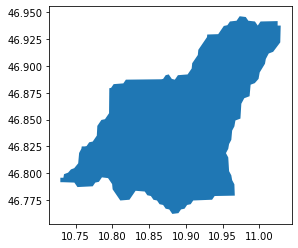

In [10]:
basin.plot();

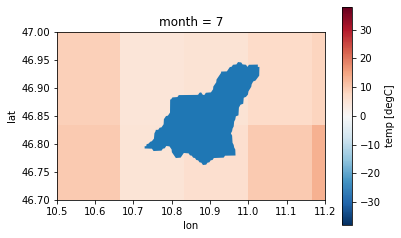

In [12]:
fig, ax = plt.subplots()
ds_cru.temp.isel(month=6).plot(ax=ax)
basin.plot(ax=ax)
ax.set_xlim(10.5, 11.2)
ax.set_ylim(46.7, 47);

(46.7, 47.0)

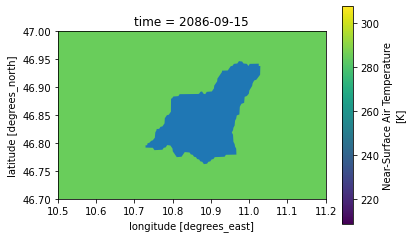

In [13]:
fig, ax = plt.subplots()
ds_t.tas.isel(time=2600).plot(ax=ax)
basin.plot(ax=ax)
ax.set_xlim(10.5, 11.2)
ax.set_ylim(46.7, 47)

Plot the selected grid points. Basically the four corner pieces.

Lets try it with another basin

In [14]:
gdf = gpd.read_file('./data/glacier_basins.shp')

In [15]:
def select_basin_data(df, basin):
    # Region of interest.
    df_sel = df.salem.roi(shape=basin)
    
    # If selection didn't return anything, expect the basin to be too small
    #  last_var = list(df_sel.variables.items())[0][0]
    #  if np.all(np.isnan(df_sel[last_var].values)):
    #      lon = basin.geometry.centroid.x
    #      lat = basin.geometry.centroid.y
    #      # We then select the point closest to the center of the basin.
    #      df_sel = df.sel(lon=lon, lat=lat, method='nearest')
    # Magic
    # With a pandas dataframe we can drop any nans without loosing valid data
    # since the multi index stacks the coordinates.
    df_sel = df_sel.to_dataframe().dropna()
    # Remove the last time steps (NaT). Couldnt figure out how to index the
    # multi index
    df_sel = df_sel[~df_sel.index.duplicated()].to_xarray()
    # Coming from pandas we have to sort the coordinates.
    df_sel = df_sel.sortby(['lat', 'lon'])
    
    return df_sel

Works for large basins

In [16]:
df_sel = select_basin_data(ds_cru, gdf.loc[[15]])

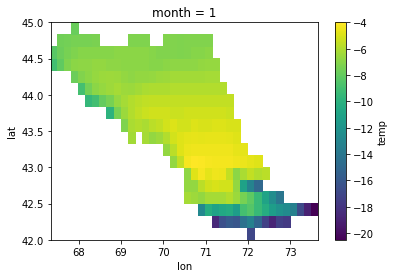

In [17]:
fig, ax = plt.subplots()
df_sel.temp.sel(month=1).plot()

And smaller basins

In [20]:
df_sel = select_basin_data(ds_cru, basin)
df_sel

<xarray.Dataset>
Dimensions:  (lat: 0, lon: 0, month: 0)
Coordinates:
  * lat      (lat) float64 
  * lon      (lon) float64 
  * month    (month) int64 
Data variables:
    elev     (lat, lon, month) float32 
    temp     (lat, lon, month) float32 
    prcp     (lat, lon, month) float32

**GCM data**

In [21]:
df_sel = select_basin_data(ds_t, gdf.loc[[15]])

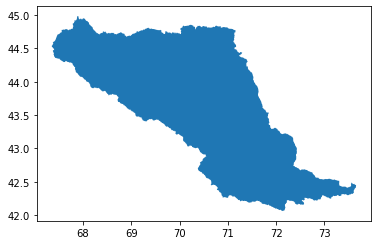

In [22]:
fig, ax = plt.subplots()
gdf.loc[[15]].geometry.plot(ax=ax);

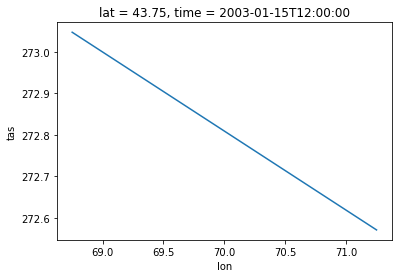

In [23]:
df_sel.sel(time='2003-01').tas.plot();

## Bias correction

In [104]:
def process_clim_data(rcp, basin):
    '''Downscales climate projection data for a rcp scenario for a
    basin.
    
    Args:
    rcp: Strings - rcp scenario
    basin: Geodataseries with basin.
    
    Return: Bias corrected data selection 
    '''
    
    # Get the projection data for the scenarios
    ft, fp = download_proj_data(rcp) 
    # And get the climate data 
    fclim = download_clim_data()
    
    # Open the datasets
    # Temperature
    with xr.open_dataset(ft) as ds:
        ds_t = ds.load()
    # Precipitation 
    with xr.open_dataset(fp) as ds:
        ds_p = ds.load()
    # Climatoloy 
    with xr.open_dataset(fclim) as ds:
        ds_clim = ds.load()
    # Let's do a coarse selection of the data first.
    minlon, minlat, maxlon, maxlat = basin.geometry.total_bounds
    # Pad the box
    pad = 1.5
    minlon -= pad
    maxlon += pad
    minlat -= pad
    maxlat += pad
    # Select the data within this box
    ds_t_sel = ds_t.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))
    ds_p_sel = ds_p.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))
    ds_clim_sel = ds_clim.sel(lon=slice(minlon, maxlon),
                              lat=slice(maxlat, minlat))
    
    # Can now compute the anomalies.
    # Temperature
    # ds_t_avg = ds_t_sel.sel(time=slice('1961-01-01', '1990-12-01'))
    # Whyyyyy no time slicing.....
    ds_t_avg = ds_t_sel.isel(time=slice(1080, 1080+(31*12))) 
    ds_t_avg = ds_t_avg.groupby('time.month').mean(dim='time')
    # Anomaly
    ds_t_ano = ds_t_sel.groupby('time.month') - ds_t_avg
    
    # Precipitation
    # ds_t_avg = ds_t_sel.sel(time=slice('1961-01-01', '1990-12-01'))
    # Whyyyyy no time slicing.....
    ds_p_avg = ds_p_sel.isel(time=slice(1080, 1080+(31*12))) 
    ds_p_avg = ds_p_avg.groupby('time.month').mean(dim='time')
    # Anomaly
    ds_p_ano = ds_p_sel.groupby('time.month') - ds_p_avg
    # Scaled anomaly?
    ds_p_scaled = ds_p_sel.groupby('time.month') / ds_p_avg
    
    # Now we can do the downscaling.
    # Temperature
    ds_t_sel_remap = ds_clim_sel.salem.grid.map_gridded_data(
                        ds_t_ano.tas.values, ds_t_ano.salem.grid,
                        interp='linear')
    
    # Precipitation
    ds_p_sel_remap = ds_clim_sel.salem.grid.map_gridded_data(
                        ds_p_ano.pr.values, ds_p_ano.salem.grid,
                        interp='linear')
    
    time = ds_t_sel.isel(time=slice(0, 2667)).time
    ds_t_sel = xr.DataArray(ds_t_sel_remap, dims=['time', 'lat', 'lon'],
                            coords={'time':time, 'lat': ds_clim_sel.lat,
                                'lon': ds_clim_sel.lon}, name='temp')
    
    ds_p_sel = xr.DataArray(ds_p_sel_remap, dims=['time', 'lat', 'lon'],
                            coords={'time':time, 'lat': ds_clim_sel.lat,
                                'lon': ds_clim_sel.lon}, name='prcp')
    # Put it all in a dataset.
    ds_selection = xr.Dataset({'temp': ds_t_sel, 'prcp': ds_p_sel})
    # Final selection of data for the basin
    ds_selection = select_basin_data(ds_selection, basin)
    # Climatology
    ds_clim_sel = select_basin_data(ds_clim, basin)
    
    # Add the bias to the climatology.
    ds_selection['temp'] = ds_selection.temp.groupby('time.month') +\
                        ds_clim_sel.temp
    ds_selection['prcp'] = ds_selection.prcp.groupby('time.month') +\
                           ds_clim_sel.prcp 
    return ds_clim_sel, ds_selection

In [105]:
ds_clim_sel, ds_selection = process_clim_data('rcp26', gdf.loc[[72]])

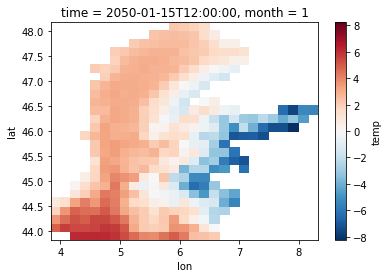

In [109]:
ds_selection.temp.sel(time='2050-01').plot();

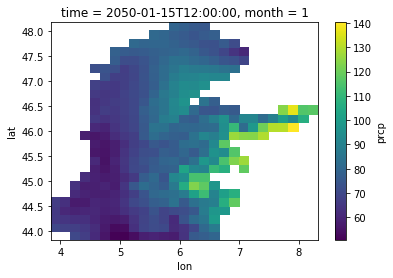

In [111]:
ds_selection.prcp.sel(time='2050-01').plot();

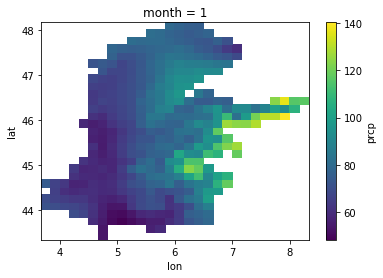

In [113]:
ds_clim_sel.prcp.sel(month=1).plot();

In [114]:
ds_selection

<xarray.Dataset>
Dimensions:  (lat: 26, lon: 27, time: 2667)
Coordinates:
  * lat      (lat) float64 43.92 44.08 44.25 44.42 ... 47.58 47.75 47.92 48.08
  * lon      (lon) float64 3.917 4.083 4.25 4.417 ... 7.75 7.917 8.083 8.25
  * time     (time) datetime64[ns] 1870-01-15T12:00:00 ... 2092-03-15T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    temp     (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    prcp     (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan